In [11]:
import torch
import matplotlib.pyplot as plt
from typing import Tuple, List

## 一、数据预处理

In [12]:
class DataProcess:
    def __init__(self, images_path: str, labels_path: str, nums: int) -> None:
        self.images_path = images_path
        self.labels_path = labels_path
        self.nums = nums
        self.images = None
        self.labels = None
        self.X = None
        self.y = None
        
        img_path = open(self.images_path, 'rb')
        try:
            # 跳过前面的magic number和图像个数、行列数
            img_path.read(16)
            images = torch.tensor(
                [int.from_bytes(img_path.read(1), byteorder='big') for _ in range(nums * 28 * 28)],
                dtype=torch.uint8)
            images = images.view(nums, 28, 28)
        finally:
            img_path.close()
        
        lb_path = open(self.labels_path, 'rb')
        try:
            # 跳过前面的magic number和标签个数
            lb_path.read(8)
            labels = torch.tensor(
                [int.from_bytes(lb_path.read(1), byteorder='big') for _ in range(nums)],
                dtype=torch.uint8)
        finally:
            lb_path.close()
        
        self.images, self.labels = images, labels
    
    
    def show_data(self, bin: bool = False, cnt: int = 5) -> None:
        fig, axs = plt.subplots(1, cnt, figsize=(10, 10))
        for i in range(cnt):
            if bin:
                axs[i].imshow(self.X[i].view(28, 28), cmap='gray')
            else:
                axs[i].imshow(self.images[i], cmap='gray')
            axs[i].set_title(f'Label: {self.y[i]}')
            axs[i].axis('off')
        plt.show()
    
    
    def reshape(self) -> None:
        # 矩阵展平
        self.X, self.y = self.images.view(self.images.shape[0], -1), self.labels
    
    
    def binary(self) -> None:
        # 二值化处理
        self.X = (self.X > 0).to(torch.uint8)
    
    
    def get_data(self) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X, self.y

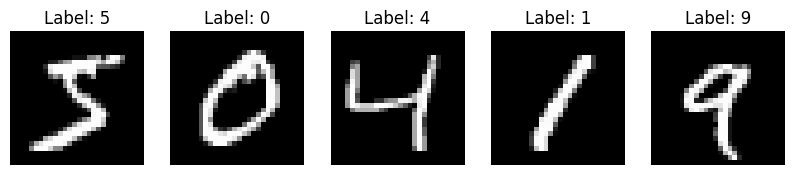

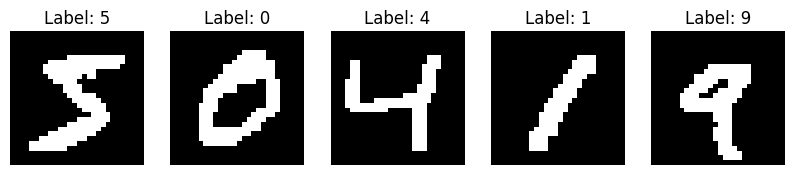

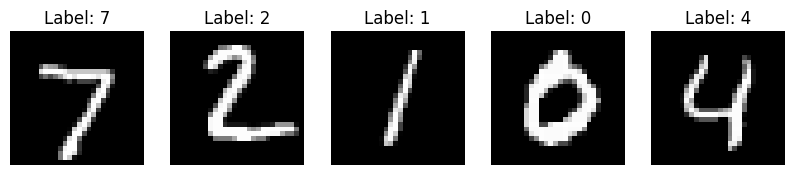

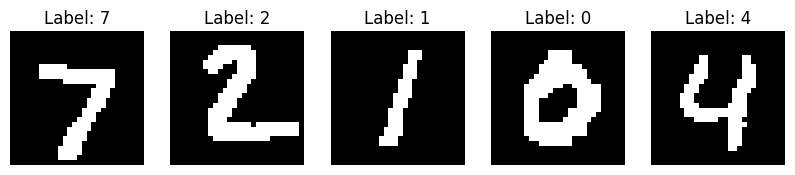

In [13]:
train_images_path = './dataset/train-images.idx3-ubyte'
train_labels_path = './dataset/train-labels.idx1-ubyte'
test_images_path = './dataset/t10k-images.idx3-ubyte'
test_labels_path = './dataset/t10k-labels.idx1-ubyte'

train = DataProcess(train_images_path, train_labels_path, 60000)
test = DataProcess(test_images_path, test_labels_path, 10000)
train.reshape()
test.reshape()

grey_train_X, train_y = train.get_data()
train.show_data(False, 5)
train.binary()
bin_train_X, train_y = train.get_data()
train.show_data(True, 5)

grey_test_X, test_y = test.get_data()
test.show_data(False, 5)
test.binary()
bin_test_X, test_y = test.get_data()
test.show_data(True, 5)

## 二、模型构建

In [14]:
class MyNaiveBayes:
    def __init__(self, opt: str = "log") -> None:
        if opt not in ["log", "nolog"]:
            raise ValueError("Invalid option for 'opt'. Must be 'log' or 'nolog'.")
        
        self.opt = opt         # 优化选项
        self.classes = None    # 类别标签
        self.cla_pri = None    # 类别先验概率
        self.feat_prob = None  # 特征条件概率
    
    
    def fit(self, train_X: torch.Tensor, train_y: torch.Tensor) -> None:
        # 计算类的先验概率
        self.classes, counts = train_y.unique(return_counts=True)
        self.cla_pri = counts.float() / train_y.shape[0]
        
        # 初始化特征条件概率矩阵
        num_feat = train_X.shape[1]
        num_cla = len(self.classes)
        self.feat_prob = torch.zeros((num_cla, num_feat))
        
        # 计算特征条件概率
        for idx, cls in enumerate(self.classes):
            cla_ids = (train_y == cls)
            cla_feat = train_X[cla_ids]
            if self.opt == "log":
                # 使用连乘取对数
                self.feat_prob[idx, :] = (cla_feat.sum(dim=0) + 1) / (cla_ids.sum() + 2)
            elif self.opt == "nolog":
                # 不使用平滑
                self.feat_prob[idx, :] = cla_feat.sum(dim=0) / cla_ids.sum()
    
    
    def predict(self, test_X: torch.Tensor) -> torch.Tensor:
        num_samples = test_X.shape[0]
        num_cla = len(self.classes)
        
        # 初始化后验概率矩阵
        log_post = torch.zeros((num_samples, num_cla))
        
        for idx, cls in enumerate(self.classes):
            if self.opt == "log":
                # 计算 log P(x|y) + log P(y)
                log_likelihood = (test_X * torch.log(self.feat_prob[idx, :]) +
                                  (1 - test_X) * torch.log(1 - self.feat_prob[idx, :])).sum(dim=1)
                log_prior = torch.log(self.cla_pri[idx])
                log_post[:, idx] = log_likelihood + log_prior
            elif self.opt == "nolog":
                # 计算 P(x|y) + log P(y)
                likelihood = (test_X * self.feat_prob[idx, :] +
                              (1 - test_X) * (1 - self.feat_prob[idx, :])).prod(dim=1)
                log_prior = torch.log(self.cla_pri[idx])
                log_post[:, idx] = torch.log(likelihood) + log_prior
        
        # 返回具有最大后验概率的类
        return self.classes[log_post.argmax(dim=1)]

## 三、模型测试与评估

### 3.1 灰度+不取对数

In [15]:
model_gray_nolog = MyNaiveBayes(opt='nolog')
model_gray_nolog.fit(grey_train_X, train_y)
pred_y_gray_nolog = model_gray_nolog.predict(grey_test_X)
accuracy_gray_nolog = (pred_y_gray_nolog == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {accuracy_gray_nolog:.4f}')

Accuracy: 0.0930


### 3.2 灰度+取对数

In [16]:
model_gray_log = MyNaiveBayes(opt='log')
model_gray_log.fit(grey_train_X, train_y)
pred_y_gray_log = model_gray_log.predict(grey_test_X)
accuracy_gray_log = (pred_y_gray_log == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {accuracy_gray_log:.4f}')

Accuracy: 0.0980


### 3.3 二值化+不取对数

In [17]:
model_bin_nolog = MyNaiveBayes(opt='nolog')
model_bin_nolog.fit(bin_train_X, train_y)
pred_y_bin_nolog = model_bin_nolog.predict(bin_test_X)
accuracy_bin_nolog = (pred_y_bin_nolog == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {accuracy_bin_nolog:.4f}')

Accuracy: 0.1698


### 3.4 二值化+取对数

In [18]:
model_bin_log = MyNaiveBayes(opt='log')
model_bin_log.fit(bin_train_X, train_y)
pred_y_bin_log = model_bin_log.predict(bin_test_X)
accuracy_bin_log = (pred_y_bin_log == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {accuracy_bin_log:.4f}')

Accuracy: 0.8413


### 3.5 柱状图可视化

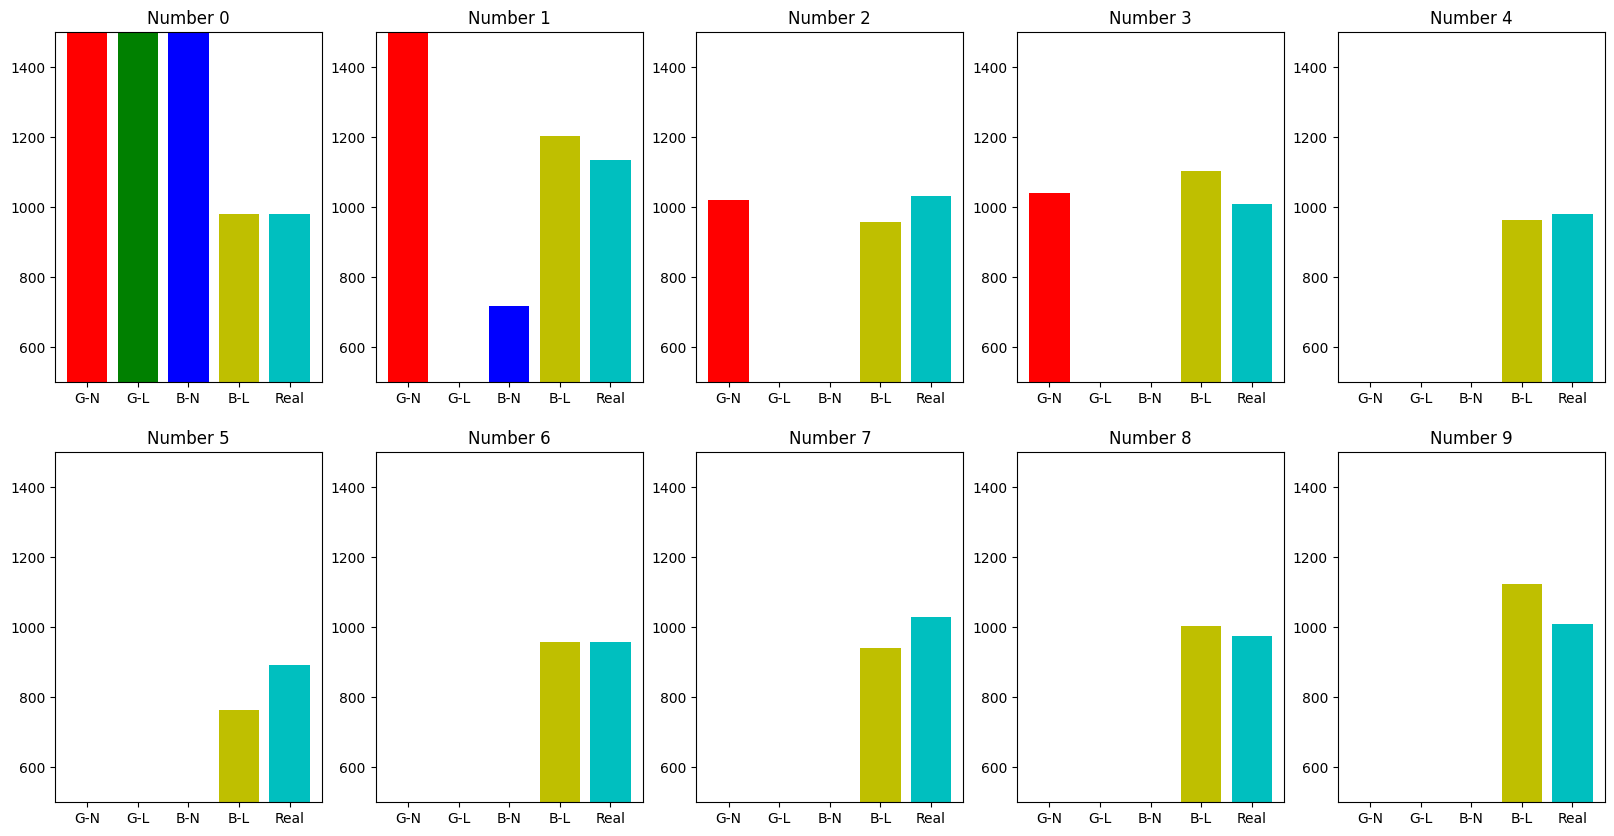

In [19]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    axs[0, i].bar(range(5), [torch.sum(pred_y_gray_nolog == i), torch.sum(pred_y_gray_log == i),
                             torch.sum(pred_y_bin_nolog == i), torch.sum(pred_y_bin_log == i),
                             torch.sum(test_y == i)], color=['r', 'g', 'b', 'y', 'c'])
    axs[0, i].set_title(f'Number {i}')
    axs[0, i].set_xticks(range(5))
    axs[0, i].set_xticklabels(['G-N', 'G-L', 'B-N', 'B-L', 'Real'])
    axs[0, i].set_ylim([500, 1500])

for i in range(5, 10):
    axs[1, i - 5].bar(range(5), [torch.sum(pred_y_gray_nolog == i), torch.sum(pred_y_gray_log == i),
                                 torch.sum(pred_y_bin_nolog == i), torch.sum(pred_y_bin_log == i),
                                 torch.sum(test_y == i)], color=['r', 'g', 'b', 'y', 'c'])
    axs[1, i - 5].set_title(f'Number {i}')
    axs[1, i - 5].set_xticks(range(5))
    axs[1, i - 5].set_xticklabels(['G-N', 'G-L', 'B-N', 'B-L', 'Real'])
    axs[1, i - 5].set_ylim([500, 1500])

plt.show()